In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from igraph import Graph, plot
from tqdm import tqdm 
from scipy.sparse.linalg import eigsh

In [3]:
#importer les graphes générés 
with open('list_of_graphs.pkl', 'rb') as fichier:
    graphs = pickle.load(fichier)

In [4]:
#nombre de communautés réel
k_vrai = range(2,50,2)

## Louvain


In [4]:
from community import community_louvain

In [5]:
k_louvain = []
for G in graphs:     
    partition = community_louvain.best_partition(G)
    k_louvain.append(max(partition.values()) + 1)

In [6]:
with open('k_louvain.pkl', 'wb') as fichier:
    pickle.dump(k_louvain, fichier)

## Walktrap

In [5]:
k_walktrap = []
for G in tqdm(graphs): 
    G_1 = Graph(edges=G.edges, directed=False)
    community = G_1.community_walktrap(weights=None,steps = 7)
    clusters = community.as_clustering()
    k_walktrap.append(len(clusters))

100%|██████████| 24/24 [1:01:50<00:00, 154.60s/it]


In [6]:
with open('k_walktrap.pkl', 'wb') as fichier:
    pickle.dump(k_walktrap, fichier)

## Spectrale avec valeurs singulières

In [26]:
from scipy.linalg import svd
from scipy.sparse.linalg import svds
def commun_number_sv_regularized(G):
    """
    Estimate the number of communities in a graph using SVD with regularization.
    
    Parameters:
    - G: networkx graph - The input graph.
    - epsilon: float - Regularization parameter to add self-loops.
    
    Returns:
    - optimal_k: int - Estimated number of communities.
    """
    # Convert the graph to an adjacency matrix
    A = nx.adjacency_matrix(G).toarray().astype(float)
    # Degree normalization
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees + 1e-10))  # Avoid division by zero
    A_normalized = D_inv_sqrt @ A @ D_inv_sqrt
    A=A_normalized

    
    # Perform Singular Value Decomposition
    n = A.shape[0]
    U, S, VT = svds(A, k=n // 49)  # S contains singular values
    sorted_singular_values = np.sort(S)[::-1]  # Sort in descending order
    
    # Find the gaps in singular values
    gaps = np.diff(sorted_singular_values)
    
    # Identify the second largest gap
    sorted_gap_indices = np.argsort(np.abs(gaps))[::-1]
    second_largest_gap_index = sorted_gap_indices[1]
    
    # Optimal number of communities
    optimal_k = second_largest_gap_index + 1
    return optimal_k

In [27]:
k_spec = []
for G in tqdm(graphs): 
    k = commun_number_sv_regularized(G)
    k_spec.append(k)

100%|██████████| 24/24 [42:57<00:00, 107.41s/it]


In [28]:
with open('k_spec.pkl', 'wb') as fichier:
    pickle.dump(k_spec, fichier)

## Spectrale matrice hessienne

In [16]:
k_spec_1 = []
for G in tqdm(graphs): 
    A = nx.adjacency_matrix(G)
    n=A.shape[0]
    D=np.diag(np.sum(A,axis=1))
    r = 2* G.number_of_edges()
    r=np.sqrt(r/n)
    H = (r**2 -1)*np.eye(n) - r*A + D
    H_eigenvalues = np.linalg.eig(H)[0]
    predicted_k=0
    for eig in H_eigenvalues:
        if eig<0:
            predicted_k+=1
    k_spec_1.append(predicted_k)

100%|██████████| 24/24 [2:04:15<00:00, 310.64s/it]


In [17]:
with open('k_spec_1.pkl', 'wb') as fichier:
    pickle.dump(k_spec_1, fichier)

## Écart spectral matrice laplacienne

In [13]:
k_spec_2 = []
for G in tqdm(graphs): 
    A = nx.adjacency_matrix(G) #matice d'adjacence 
    D=np.diag(np.sum(A,axis=1)) #matrice de degrès
    L = D - A #matrice laplacienne 
    eigenvalues, eigenvectors = eigsh(L, k=A.shape[0], which='SM')
    eigenvalues = np.sort(eigenvalues)
    spectral_gaps = np.diff(eigenvalues)
    largest_gap_index = np.argmax(spectral_gaps)
    k = largest_gap_index + 1
    k_spec_2.append(k)

  0%|          | 0/24 [00:00<?, ?it/s]/var/folders/gp/mjd24qcx5yz_0yn2p3wsmvmh0000gn/T/ipykernel_97907/1760283947.py:6: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=A.shape[0], which='SM')
100%|██████████| 24/24 [52:32<00:00, 131.37s/it]


In [15]:
with open('k_spec_2.pkl', 'wb') as fichier:
    pickle.dump(k_spec_2, fichier)

## Importer les valeurs de k pour différentes méthodes 

In [29]:
with open('k_louvain.pkl', 'rb') as fichier:
    k_louvain = pickle.load(fichier)
    
with open('k_walktrap.pkl', 'rb') as fichier:
    k_walktrap = pickle.load(fichier)

with open('k_spec.pkl', 'rb') as fichier:
    k_spec = pickle.load(fichier)

with open('k_spec_1.pkl', 'rb') as fichier:
    k_spec_1 = pickle.load(fichier)

with open('k_spec_2.pkl', 'rb') as fichier:
    k_spec_2 = pickle.load(fichier)

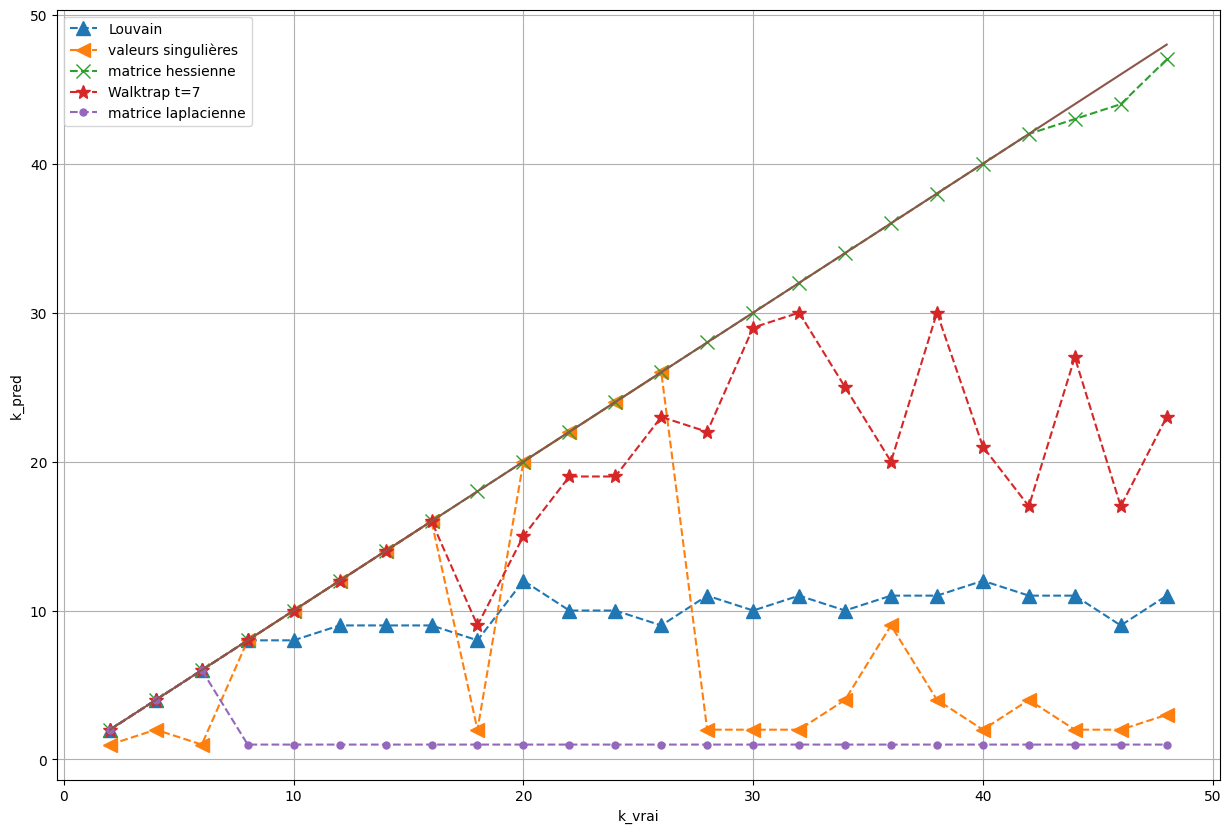

In [42]:
plt.figure(figsize=(15,10))
plt.plot(k_vrai , k_louvain , label='Louvain',linestyle='--', marker='^',markersize = 10)
plt.plot(k_vrai , k_spec , label='valeurs singulières',linestyle='--', marker='<',markersize = 10)
plt.plot(k_vrai , k_spec_1 , label='matrice hessienne',linestyle='--', marker='x',markersize =10)
plt.plot(k_vrai , k_walktrap , label='Walktrap t=7',linestyle='--', marker='*',markersize = 10)
plt.plot(k_vrai , k_spec_2 , label='matrice laplacienne',linestyle='--', marker='.',markersize = 10)
plt.plot(k_vrai , k_vrai)
plt.grid(True)
plt.ylabel('k_pred')
plt.xlabel('k_vrai')
plt.legend()
plt.show()